In [18]:
import os,json
import sys
import augur
import sqlalchemy as s
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plot
import matplotlib.dates as mdates
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install xlrd
#!{sys.executable} -m pip install imblearn


[nltk_data] Downloading package punkt to /Users/gogginsS/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gogginsS/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/gogginsS/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [19]:
if("notebooks" in os.getcwd()):
    os.chdir("../SentiCR")
    from SentiCR.SentiCR import SentiCR

sentiment_analyzer = SentiCR()
if("notebooks" not in os.getcwd()):
    os.chdir("../../notebooks")

augurApp = augur.Application('../augur.config.json')

connect = augurApp.ghtorrentplus()

Reading data from oracle..
Training classifier model..


/Users/gogginsS/anaconda3/envs/augur/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
table_names = s.inspect(connect.db).get_table_names()
print(table_names)

if("mailing_list_jobs" in table_names):
    lists_createdSQL = s.sql.text("""SELECT project FROM mailing_list_jobs""")
    df1 = pd.read_sql(lists_createdSQL, connect.db)
    print(df1)
    val = True

['github_issues', 'github_issues_2', 'github_issues_repo_jobs', 'github_issues_sentiment_scores', 'github_issues_sentiment_scores_senticr', 'github_pull_request_repo_jobs', 'github_pull_requests', 'github_pull_requests_2', 'github_pull_requests_sentiment_scores', 'github_pull_requests_sentiment_scores_2', 'github_pull_requests_sentiment_scores_senticr', 'issue_response_time', 'issue_response_time2', 'issue_response_time_3', 'mail_lists', 'mail_lists_sentiment_scores', 'mail_lists_sentiment_scores_senticr', 'mailing_list_jobs']
    project
0  announce
1  announce


In [21]:
col = 'score','sentiment'
columns1 = 'augurmsgID', 'backend_name','project','mailing_list','category',\
           'message_part','message_parts_tot', 'subject','date',\
           'message_from','message_id','message_text'
df3 = pd.DataFrame(columns = col)
df_list = pd.DataFrame(columns = columns1)
for i in df1['project'].values:
    print(i,"Mailing List")
    SQL = s.sql.text("""SELECT * 
    FROM mail_lists WHERE mailing_list = """ +  "'" + i + "'")
    df2 = pd.read_sql(SQL, connect.db)
    df_list = df_list.append(df2)
    #print(df2)
    grouped = df2.groupby('message_id').groups
    print("Here!!!!")
    #print("\n\n","-"*70,"\n\n")
    for group in grouped:
        parts = 0
        numb = len(df2.loc[df2['message_id'] == group]['message_parts_tot'].tolist())
        message = (df2.loc[df2['message_id'] == group]['message_text']).tolist()
        message_text = ''.join(message)
        #print(message_text)
        score=sentiment_analyzer.get_sentiment_polarity(message_text)
        score = int(score[0])
        compound = parts = 0
        sentiment = "Positive"
        if(score == -1):
            sentiment = "Negative"
        #print(message)
        for i in range(numb):
            li = [ [score, sentiment] ]
            df_temp = pd.DataFrame(li,columns = col)
            #print(df_temp['score'])
            df3 = df3.append(df_temp)
            #print(df3)
    print("\n\n")

announce Mailing List
Here!!!!



announce Mailing List
Here!!!!





In [22]:
df3 = df3.reset_index(drop=True)
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

print(combine.head())
print(combine.shape)
combine.to_sql(name='mail_lists_sentiment_scores_senticr',con=connect.db,\
               if_exists='replace',index=False)

  augurmsgID backend_name                                        project  \
0          1    Pipermail  https://lists.gluster.org/pipermail/announce/   
1          2    Pipermail  https://lists.gluster.org/pipermail/announce/   
2          3    Pipermail  https://lists.gluster.org/pipermail/announce/   
3          4    Pipermail  https://lists.gluster.org/pipermail/announce/   
4          5    Pipermail  https://lists.gluster.org/pipermail/announce/   

  mailing_list category message_part message_parts_tot  \
0     announce  message            1                 2   
1     announce  message            2                 2   
2     announce  message            1                 2   
3     announce  message            2                 2   
4     announce  message            1                 2   

                                            subject                date  \
0  Announcing: Gluster Community Day @ Rackspace SF 2013-08-13 20:36:24   
1  Announcing: Gluster Community Day @ Racks

(392,)
(392,)


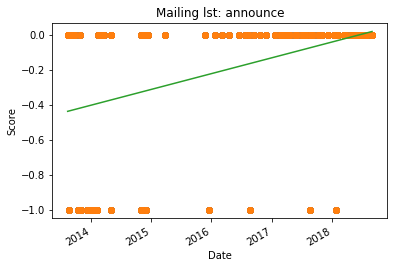

In [23]:
grouped = combine.groupby('mailing_list').groups
dates = []
mail_list = None
j = 0
for group in grouped:
    dates = (combine.loc[combine['mailing_list'] == group]['date']).tolist()
    values = []
    for val in dates:
        #print(val)
        values.append((combine.loc[combine['date'] == val]['score']).tolist()[0])
    #values = (combine.loc[combine['mailing_list'] == group]['score']).unique().tolist()
    x = np.array(dates)
    #dates = np.unique(x)
    #print(dates)
    dates1 = [r.to_pydatetime() for r in x]
    fin_dates = mdates.date2num(dates1)
    fin_values = np.asarray(values)
    print(fin_dates.shape)
    print(fin_values.shape)
    plot.plot_date(fin_dates, fin_values)
    #plot.plot(fin_dates,fin_values)
    plot.gcf().autofmt_xdate()
    plot.title("Mailing lst: "+ group)
    plot.ylabel('Score')
    plot.xlabel('Date')
    #print(fin_dates)
    slope, intercept, r_value, p_value, std_err = stats.linregress(fin_dates,fin_values)
    line = slope*fin_dates+intercept
    plot.plot(fin_dates,fin_values,'o', fin_dates, line)
    #plot.savefig('foo' + str(x) + '.png')
    #x+=1
    plot.show()